### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# style (feel free to change/remove)
plt.style.use("seaborn-v0_8-colorblind")

# --- Config ---
CSV_PATH = "../original_data/clean_data.csv"
LOAD_COL = "day_ahead_load_forecast" 

# --- Load ---
df = pd.read_csv(CSV_PATH, parse_dates=[0])
df = (
    df.rename(columns={df.columns[0]: "dt"})
      .set_index("dt")
      .sort_index()
)

# --- Time helpers ---
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday               # Monday=0
df["is_weekend"] = df["weekday"] >= 5
df["year"] = df.index.year
df["month_period"] = df.index.to_period("M")

### Helpers

In [2]:
def qstats(s: pd.Series, prefix: str) -> pd.Series:
    """Return q25/median/q75 with a prefix."""
    q = s.quantile([0.25, 0.5, 0.75])
    return pd.Series({
        f"{prefix}_q25": float(q.loc[0.25]),
        f"{prefix}_median": float(q.loc[0.5]),
        f"{prefix}_q75": float(q.loc[0.75]),
    })

def month_metrics(g: pd.DataFrame) -> pd.Series:
    """
    Build monthly metrics for weekdays & weekends from DAILY profiles:
      - morning_ramp_0408 (L08 - L04)
      - evening_minus_midday (max 16..20 - mean 11..14)
      - peak_hour (argmax over 0..23)
    Stored as q25/median/q75 across days in that month.
    """
    out = {}
    for label, mask in [("weekday", ~g["is_weekend"]), ("weekend", g["is_weekend"])]:
        sub = g.loc[mask]
        if sub.empty:
            out.update({
                f"morning_ramp_0408_{label}_q25": np.nan,
                f"morning_ramp_0408_{label}_median": np.nan,
                f"morning_ramp_0408_{label}_q75": np.nan,
                f"evening_minus_midday_{label}_q25": np.nan,
                f"evening_minus_midday_{label}_median": np.nan,
                f"evening_minus_midday_{label}_q75": np.nan,
                f"peak_hour_{label}_q25": np.nan,
                f"peak_hour_{label}_median": np.nan,
                f"peak_hour_{label}_q75": np.nan,
            })
            continue

        tmp = sub.copy()
        tmp["date"] = tmp.index.date
        tbl = (
            tmp.pivot_table(index="date", columns="hour", values=LOAD_COL, aggfunc="mean")
               .reindex(columns=range(24))
        )

        morning_ramp = tbl[8] - tbl[4]
        midday_mean = tbl[[11, 12, 13, 14]].mean(axis=1)
        evening_peak = tbl[[16, 17, 18, 19, 20]].max(axis=1)
        evening_minus_midday = evening_peak - midday_mean
        peak_hour = tbl.idxmax(axis=1).astype(int)

        out.update(qstats(morning_ramp, f"morning_ramp_0408_{label}").to_dict())
        out.update(qstats(evening_minus_midday, f"evening_minus_midday_{label}").to_dict())
        out.update(qstats(peak_hour, f"peak_hour_{label}").to_dict())
    return pd.Series(out)

def derivative_iqr_by_year(data: pd.DataFrame, day_mask: pd.Series, order: int = 1):
    """
    For each year, compute daily profiles (24h), take numerical derivative(s) along hours,
    then return q25/median/q75 across days at each hour.
    """
    sub = data.loc[day_mask].copy()
    sub["date"] = sub.index.date
    out = {}
    for y, g in sub.groupby("year"):
        tbl = (
            g.pivot_table(index="date", columns="hour", values=LOAD_COL, aggfunc="mean")
             .reindex(columns=range(24))
        ).to_numpy()
        der = np.gradient(tbl, axis=1) if order == 1 else np.gradient(np.gradient(tbl, axis=1), axis=1)
        out[y] = pd.DataFrame({
            "q25": np.nanpercentile(der, 25, axis=0),
            "median": np.nanpercentile(der, 50, axis=0),
            "q75": np.nanpercentile(der, 75, axis=0)
        }, index=range(24))
    return out

### Monthly metrics

In [3]:
monthly_metrics = (
    df.groupby("month_period", sort=True)
      .apply(month_metrics)
      .reset_index()
)
monthly_metrics["month_start"] = monthly_metrics["month_period"].dt.to_timestamp()
monthly_metrics["year"] = monthly_metrics["month_start"].dt.year
monthly_metrics["month_num"] = monthly_metrics["month_start"].dt.month

yearly_metrics = (
    monthly_metrics
    .groupby("year", as_index=False)
    .agg({
        # using weekday medians as representative; adjust if you prefer q25/mean
        "morning_ramp_0408_weekday_median": "mean",
        "evening_minus_midday_weekday_median": "mean",
        "peak_hour_weekday_median": "mean",
        "morning_ramp_0408_weekend_median": "mean",
        "evening_minus_midday_weekend_median": "mean",
        "peak_hour_weekend_median": "mean",
    })
    .rename(columns={
        "morning_ramp_0408_weekday_median": "year_mean_morning_ramp_wd",
        "evening_minus_midday_weekday_median": "year_mean_eve_minus_mid_wd",
        "peak_hour_weekday_median": "year_mean_peak_hour_wd",
        "morning_ramp_0408_weekend_median": "year_mean_morning_ramp_we",
        "evening_minus_midday_weekend_median": "year_mean_eve_minus_mid_we",
        "peak_hour_weekend_median": "year_mean_peak_hour_we",
    })
)

monthly_metrics_rounded = monthly_metrics.drop(columns=["month_period"]).copy()
yearly_metrics_rounded = yearly_metrics.copy()

round_cols = [c for c in monthly_metrics_rounded.columns if c.endswith(("_q25","_median","_q75"))]
monthly_metrics_rounded[round_cols] = monthly_metrics_rounded[round_cols].round(3)
yearly_metrics_rounded.iloc[:, 1:] = yearly_metrics_rounded.iloc[:, 1:].round(3)

monthly_metrics_rounded.to_csv("monthly_load_profile_metrics.csv", index=False)
yearly_metrics_rounded.to_csv("yearly_load_profile_metrics.csv", index=False)

/var/folders/8w/zmlxvyj52l7_fdlcpjyc4rd40000gn/T/ipykernel_12831/1568903763.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(month_metrics)


### Duck Curves

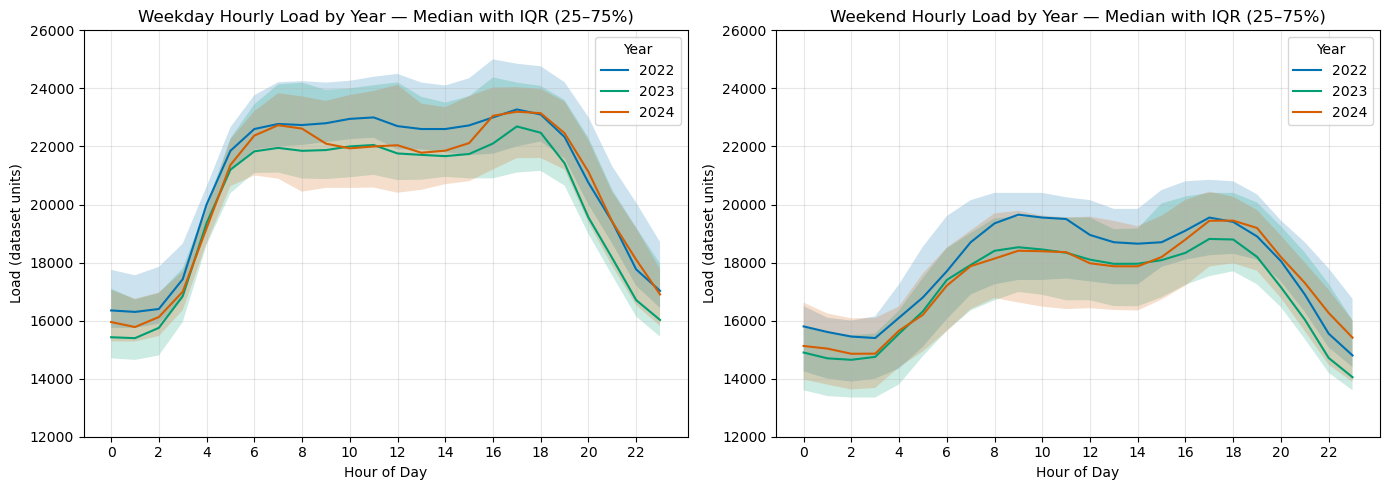

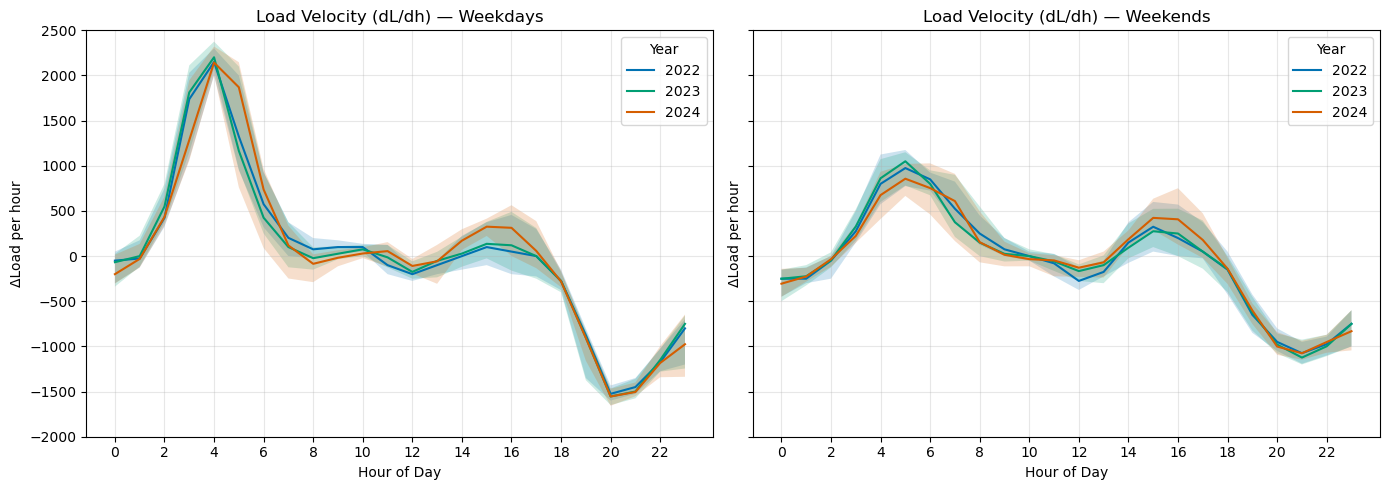

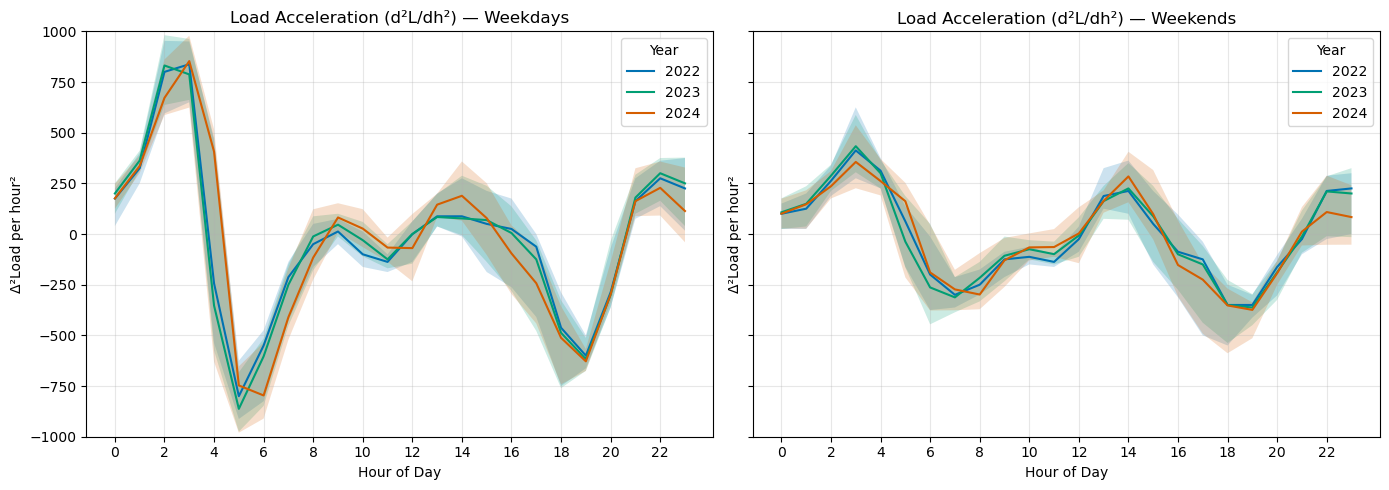

In [4]:
weekday = df.loc[~df["is_weekend"]]
weekend = df.loc[df["is_weekend"]]

wd_q = (
    weekday.groupby(["year", "hour"])[LOAD_COL]
           .quantile([0.25, 0.5, 0.75])
           .unstack(-1)
           .rename(columns={0.25: "q25", 0.5: "median", 0.75: "q75"})
           .sort_index()
)
we_q = (
    weekend.groupby(["year", "hour"])[LOAD_COL]
           .quantile([0.25, 0.5, 0.75])
           .unstack(-1)
           .rename(columns={0.25: "q25", 0.5: "median", 0.75: "q75"})
           .sort_index()
)

years_wd = sorted(wd_q.index.get_level_values("year").unique())
years_we = sorted(we_q.index.get_level_values("year").unique())
hrs = np.arange(24)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Weekdays
ax = axes[0]
for y in years_wd:
    sub = wd_q.loc[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Weekday Hourly Load by Year — Median with IQR (25–75%)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Load (dataset units)")
ax.set_ylim(12000,26000)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

# Weekends
ax = axes[1]
for y in years_we:
    sub = we_q.loc[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Weekend Hourly Load by Year — Median with IQR (25–75%)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Load (dataset units)")
ax.set_ylim(12000,26000)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()

# Velocity (1st derivative)
wd_vel = derivative_iqr_by_year(df, ~df["is_weekend"], order=1)
we_vel = derivative_iqr_by_year(df,  df["is_weekend"], order=1)

hrs = np.arange(24)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

ax = axes[0]
for y in sorted(wd_vel.keys()):
    sub = wd_vel[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Load Velocity (dL/dh) — Weekdays")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("ΔLoad per hour")
ax.set_ylim(-2000, 2500)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

ax = axes[1]
for y in sorted(we_vel.keys()):
    sub = we_vel[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Load Velocity (dL/dh) — Weekends")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("ΔLoad per hour")
ax.set_ylim(-2000, 2500)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()

# Acceleration (2nd derivative)
wd_acc = derivative_iqr_by_year(df, ~df["is_weekend"], order=2)
we_acc = derivative_iqr_by_year(df,  df["is_weekend"], order=2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

ax = axes[0]
for y in sorted(wd_acc.keys()):
    sub = wd_acc[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Load Acceleration (d²L/dh²) — Weekdays")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Δ²Load per hour²")
ax.set_ylim(-1000, 1000)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

ax = axes[1]
for y in sorted(we_acc.keys()):
    sub = we_acc[y]
    ax.plot(hrs, sub["median"], label=str(y))
    ax.fill_between(hrs, sub["q25"], sub["q75"], alpha=0.2)
ax.set_title("Load Acceleration (d²L/dh²) — Weekends")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Δ²Load per hour²")
ax.set_ylim(-1000, 1000)
ax.set_xticks(np.arange(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()

### Duck Curve Differences and Morning Ramp

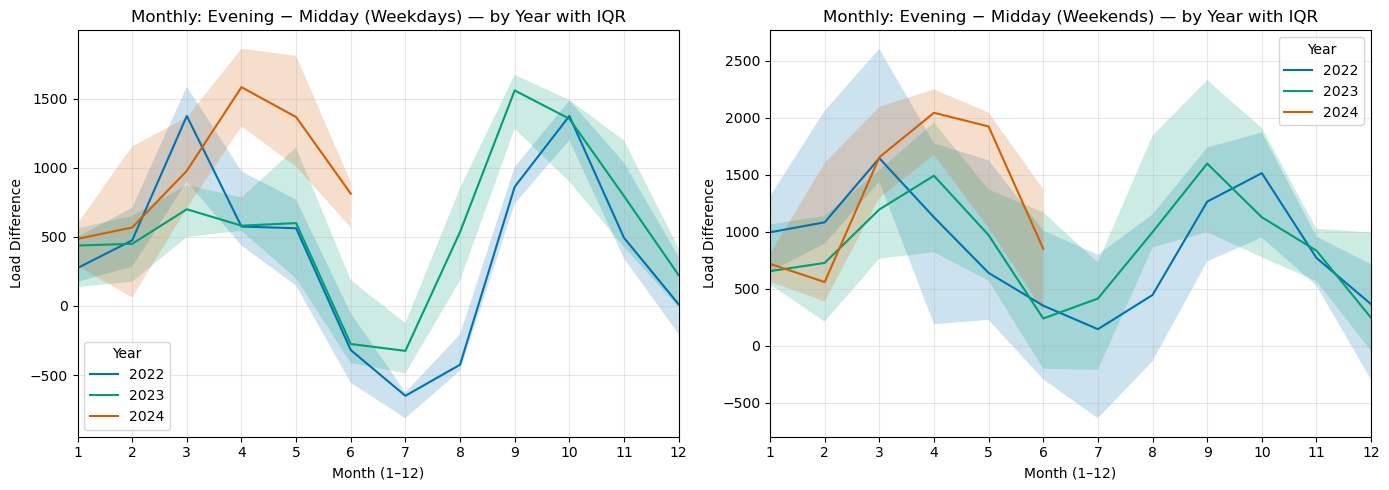

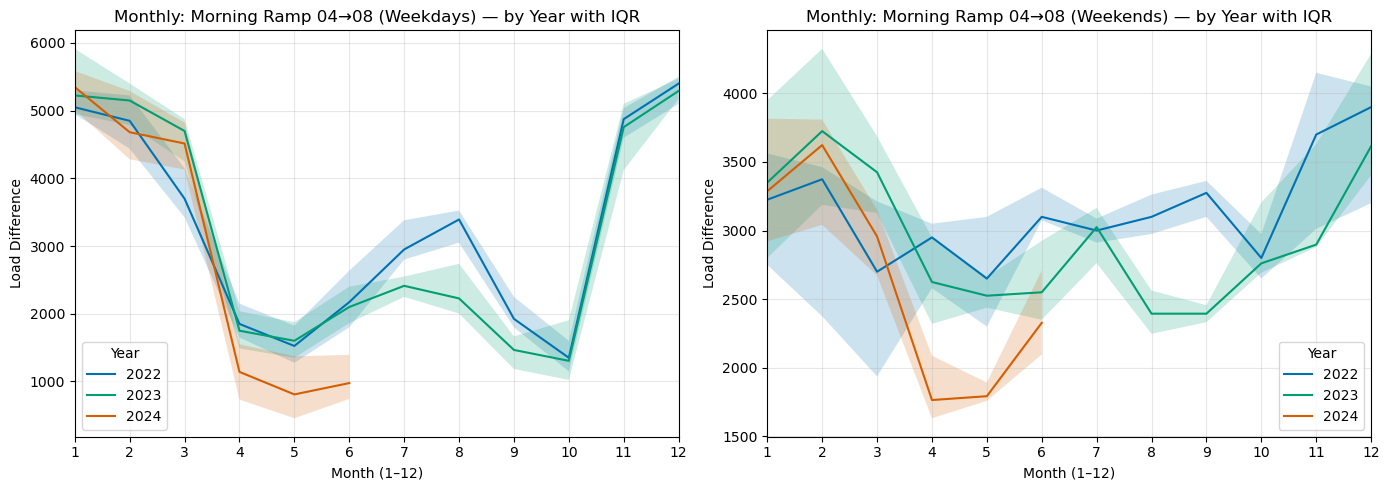

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Evening - Midday (Weekdays)
ax = axes[0]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["evening_minus_midday_weekday_median"]
    q25 = sub["evening_minus_midday_weekday_q25"]
    q75 = sub["evening_minus_midday_weekday_q75"]
    ax.plot(x, med, label=str(y))
    ax.fill_between(x, q25, q75, alpha=0.2)
ax.set_title("Monthly: Evening − Midday (Weekdays) — by Year with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Load Difference")
ax.set_xlim(1, 12); ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3); ax.legend(title="Year")

# Evening - Midday (Weekends)
ax = axes[1]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["evening_minus_midday_weekend_median"]
    q25 = sub["evening_minus_midday_weekend_q25"]
    q75 = sub["evening_minus_midday_weekend_q75"]
    ax.plot(x, med, label=str(y))
    ax.fill_between(x, q25, q75, alpha=0.2)
ax.set_title("Monthly: Evening − Midday (Weekends) — by Year with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Load Difference")
ax.set_xlim(1, 12); ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3); ax.legend(title="Year")

plt.tight_layout()
plt.show()

# Morning ramp (04→08)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Weekdays
ax = axes[0]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["morning_ramp_0408_weekday_median"]
    q25 = sub["morning_ramp_0408_weekday_q25"]
    q75 = sub["morning_ramp_0408_weekday_q75"]
    ax.plot(x, med, label=str(y))
    ax.fill_between(x, q25, q75, alpha=0.2)
ax.set_title("Monthly: Morning Ramp 04→08 (Weekdays) — by Year with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Load Difference")
ax.set_xlim(1, 12); ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3); ax.legend(title="Year")

# Weekends
ax = axes[1]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    med = sub["morning_ramp_0408_weekend_median"]
    q25 = sub["morning_ramp_0408_weekend_q25"]
    q75 = sub["morning_ramp_0408_weekend_q75"]
    ax.plot(x, med, label=str(y))
    ax.fill_between(x, q25, q75, alpha=0.2)
ax.set_title("Monthly: Morning Ramp 04→08 (Weekends) — by Year with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Load Difference")
ax.set_xlim(1, 12); ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3); ax.legend(title="Year")

plt.tight_layout()
plt.show()


### Peak Hour

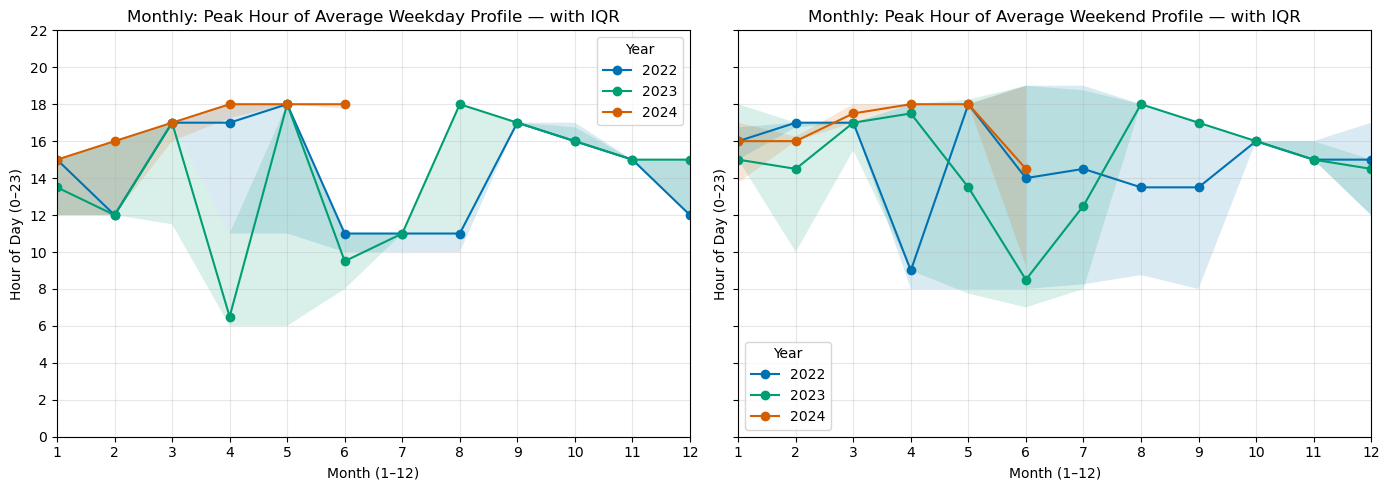

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Weekdays
ax = axes[0]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    ax.plot(x, sub["peak_hour_weekday_median"], marker="o", linestyle="-", label=str(y))
    # optional IQR shading:
    ax.fill_between(x, sub["peak_hour_weekday_q25"], sub["peak_hour_weekday_q75"], alpha=0.15)
ax.set_title("Monthly: Peak Hour of Average Weekday Profile — with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Hour of Day (0–23)")
ax.set_xlim(1, 12); ax.set_xticks(range(1, 13))
ax.set_yticks(range(0, 24, 2))
ax.grid(True, alpha=0.3); ax.legend(title="Year")

# Weekends
ax = axes[1]
for y in sorted(monthly_metrics["year"].unique()):
    sub = monthly_metrics.loc[monthly_metrics["year"] == y].sort_values("month_num")
    x = sub["month_num"]
    ax.plot(x, sub["peak_hour_weekend_median"], marker="o", linestyle="-", label=str(y))
    ax.fill_between(x, sub["peak_hour_weekend_q25"], sub["peak_hour_weekend_q75"], alpha=0.15)
ax.set_title("Monthly: Peak Hour of Average Weekend Profile — with IQR")
ax.set_xlabel("Month (1–12)")
ax.set_ylabel("Hour of Day (0–23)")
ax.set_xlim(1, 12); ax.set_xticks(range(1, 13))
ax.set_yticks(range(0, 24, 2))
ax.grid(True, alpha=0.3); ax.legend(title="Year")

plt.tight_layout()
plt.show()

### Industrial Sector Proxy

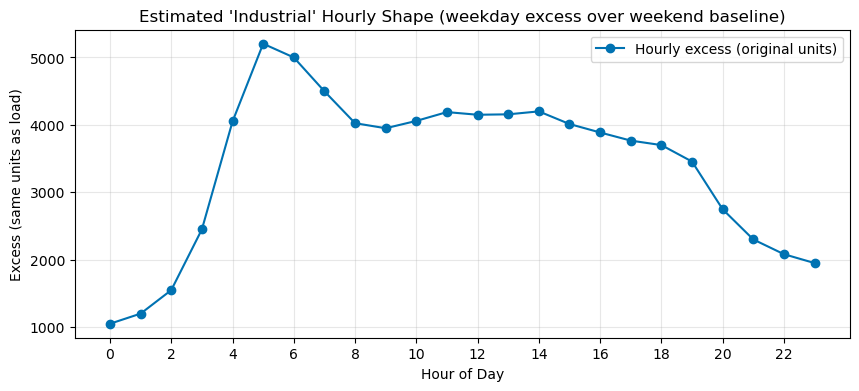

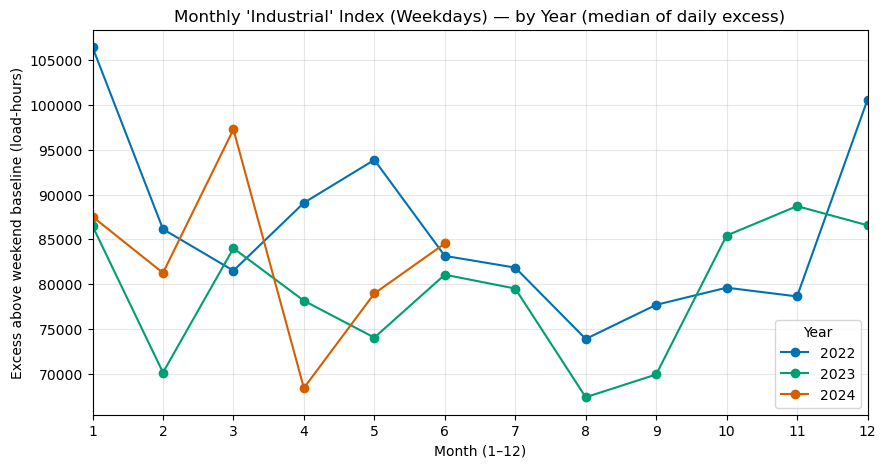

In [7]:
# Weekend baseline: median by (month_period, hour)
weekend_baseline = (
    df.loc[df["is_weekend"]]
      .groupby(["month_period", "hour"])[LOAD_COL]
      .median()
      .unstack("hour")
      .reindex(columns=range(24))
      .sort_index()
)

# Attaching baseline to every timestamp by (month_period, hour)
b_stack = (
    weekend_baseline.stack()
    .rename("baseline")
    .reset_index()
    .rename(columns={"level_1": "hour"})
)

tmp = (
    df[["month_period", "hour"]]
    .reset_index()
    .merge(b_stack, on=["month_period", "hour"], how="left")
)

df = df.copy()
df["baseline"] = tmp["baseline"].values
df["date"] = df.index.date

# Keep only weekdays
wd = df.loc[~df["is_weekend"]].copy()

# Excess above the weekend baseline (clip negatives to zero)
wd["excess"] = (wd[LOAD_COL] - wd["baseline"]).clip(lower=0)

# (A1) Hourly "industrial-like" shape = median weekday excess by hour
I_hour = (
    wd.groupby("hour")["excess"]
      .median()
      .reindex(range(24))
      .fillna(0.0)
)

# Normalized version (optional; useful for reconstruction/plotting)
I_shape = I_hour / I_hour.sum() if I_hour.sum() > 0 else I_hour

# (A2) Daily intensity (original numbers): sum of excess over the 24 hours
wd_day_excess = (
    wd.pivot_table(index="date", columns="hour", values="excess", aggfunc="mean")
      .reindex(columns=range(24))
      .fillna(0.0)
)
s_d = wd_day_excess.sum(axis=1)  # units: load-hours (since Δt=1h)

# Tidy for monthly plotting
s_d_series = s_d.rename("industrial_index").to_frame()
s_d_series["year"]  = pd.to_datetime(s_d_series.index).year
s_d_series["month"] = pd.to_datetime(s_d_series.index).month

# Monthly medians (three curves later)
mm_idx = (
    s_d_series
    .groupby(["year","month"])["industrial_index"]
    .median()
    .reset_index()
)

# (P1) Hourly shape (median excess by hour) — original and normalized for reference
plt.figure(figsize=(10,4))
plt.plot(I_hour.index, I_hour.values, marker="o", label="Hourly excess (original units)")
plt.title("Estimated 'Industrial' Hourly Shape (weekday excess over weekend baseline)")
plt.xlabel("Hour of Day")
plt.ylabel("Excess (same units as load)")
plt.xticks(range(0,24,2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# (P2) Monthly industrial index (median of daily excess), three curves by year
plt.figure(figsize=(10,5))
for y in sorted(mm_idx["year"].unique()):
    sub = mm_idx.loc[mm_idx["year"] == y]
    plt.plot(sub["month"], sub["industrial_index"], marker="o", linestyle="-", label=str(y))
plt.title("Monthly 'Industrial' Index (Weekdays) — by Year (median of daily excess)")
plt.xlabel("Month (1–12)")
plt.ylabel("Excess above weekend baseline (load-hours)")
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.legend(title="Year")
plt.show()

### Summary

In [8]:
ind_stats = (
    mm_idx.groupby("year")["industrial_index"]
         .agg(industrial_index_median="median",
              industrial_index_min="min",
              industrial_index_max="max")
         .reset_index()
)

# Merge with yearly metrics
key_numbers = (
    yearly_metrics_rounded.merge(ind_stats, on="year", how="left")
    .copy()
)

# Round numeric columns for readability
num_cols = key_numbers.columns[key_numbers.columns != "year"]
key_numbers[num_cols] = key_numbers[num_cols].astype(float).round(3)

# Save and print
key_numbers.to_csv("key_numbers_summary.csv", index=False)
print("Saved: key_numbers_summary.csv\n")
print(key_numbers.to_string(index=False))

Saved: key_numbers_summary.csv

 year  year_mean_morning_ramp_wd  year_mean_eve_minus_mid_wd  year_mean_peak_hour_wd  year_mean_morning_ramp_we  year_mean_eve_minus_mid_we  year_mean_peak_hour_we  industrial_index_median  industrial_index_min  industrial_index_max
 2022                   3253.292                     384.375                  14.333                   3147.833                     860.417                  14.875                 82494.50              73875.00              106450.0
 2023                   3165.500                     553.229                  14.042                   2940.500                     872.698                  14.917                 80275.50              67367.50               88707.0
 2024                   2912.000                     966.042                  17.000                   2625.250                    1289.833                  16.667                 82890.25              68399.25               97275.0
